- **Created:** [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) with thanks to [Petar Raykov](https://www.mrc-cbu.cam.ac.uk/people/Petar.Raykov)
- **Date:** November 2024
- **conda environment**: This uses the [mri environment](https://github.com/RikHenson/PythonNeuroimagingCourse/blob/main/mri_environment.yml)

# Functional Connectivity

This notebook introduces two types of fMRI connectivity (for a single subject):

1. Task-based "beta-series regression" (BSR) to test whether the correlation between single-trial BOLD responses between two regions/voxels differs as a function of trial-type (condition). This starts with BSR between two ROIs (using NiftiMaskers from previous notebooks) and then shows BSR between a seed ROI and all other voxels in an image.

2. State-based "time-series correlation" (TSC) across TRs between ROIs, having removed confounds like motion artifacts, WM/CSF signal, global signal etc. Normally this type of analysis is done on resting-state data (or data from continuous stimuli like movie watching), but there are no such data in the dataset we are using. Nonetheless, we can simulate resting-state data by removing task effects (i.e., treating the task regressors in our design matrix as another confound). The notebook finishes with creation of a "functional connectome" of connectivity between every pair of ROIs in an atlas, which is the type of connectivity matrix used in the next notebook on network analysis.

It does not yet demonstrate "psychophysiological interactions" (PPIs) - a third type of connectivity in which a model is created with a timeseries, a task regressor and the interaction between these two - which I hope to add in future. 

Note that there are also many powerful data-driven methods (like ICA) that can be used to estimate function networks of regions with similar timeseries (see for example [Smitha et al (2017)](https://pmc.ncbi.nlm.nih.gov/articles/PMC5524274) for example review), as well as complex dynamical models (like DCM or HMMs) that get closer to measuring true "effective connectivity" (by simulating a full network of regions, see [Stephan & Friston (2011)](https://pmc.ncbi.nlm.nih.gov/articles/PMC3013343/) for example) - but these are not covered here.

Finally, we are using unidimensional connectivity, averaging values across voxels within each ROI, though there are also multidimensional ways to estimate connectivity (see [Basti et al (2020)](https://pubmed.ncbi.nlm.nih.gov/32682988/) for example review).

## 0. Getting Ready

As usual, we need some python packages like below:

In [1]:
import matplotlib.pyplot as plt # plotting
# to show plots in cell
%matplotlib inline   

import os           # To interact with the operating system, including files and paths (e.g. path.join)
import bids.layout  # To fetch data from BIDS-compliant datasets
import numpy        # This lets python process arrays/matrices
import pandas       # To use "dataframes"      
import nibabel      # Basic nifti image utilities

import nilearn                  # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import input_data  # includes NiftiMasker, NiftiLabelsMasker
from nilearn.maskers import NiftiMasker, NiftiSpheresMasker # For extracting data from images
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import datasets    # for atlases below
from nilearn.connectome import ConnectivityMeasure

import scipy                     # statistical tools
from scipy.stats import pearsonr # like Pearson correlation

And set-up our input and output directories:

In [2]:
wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
out_dir = os.path.join(wd, 'results', 'fcon')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
os.chdir(out_dir)
print(f"Working directory currently {os.getcwd()}")

fmri_data_dir = os.path.join(wd, 'data') # data in BIDS format
fmri_results_dir = os.path.join(wd, 'results') # results in BIDS format

layout = bids.layout.BIDSLayout(fmri_data_dir, derivatives = True)
layout.add_derivatives(os.path.join(fmri_results_dir, 'first-level'))

Working directory currently /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/fcon


## 1. Task-based Beta-series regression

We are going to re-use the trial onsets and single-trial Betas from the previous notebook. For reasons given in that notebook, we are going to focus on Initial (Ini) and Delayed (Del) presentations of Famous Faces (FF) and Scrambled Faces (SF).

In [6]:
sID = '15' # same subject we used before

events_files = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print("Found " + str(len(events_files)) + " event files")

conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
conditions_of_interest = ['IniFF', 'DelFF', 'IniSF', 'DelSF'] # see previous notebook for justification of focusing on these 4 trial-types
other_conditions = [val for val in conditions if val not in conditions_of_interest]

mvpa_dir = os.path.join(wd, 'results', 'mvpa') # where the beta images were saved from MVPA notebook, which we need for beta series regression
model_name = 'LSA_2FF_2SF' 
outdir = os.path.join(mvpa_dir, model_name, 'sub-' + sID)

beta_filenames = [] # name of 4D files that contain Beta estimates for single trials for each run
trial_labels = []
for run, events_file in enumerate(events_files):
    beta_file = os.path.join(outdir, os.path.basename(events_file).split("events")[0] + model_name + '_betas.nii.gz')
    print(beta_file)
    beta_filenames.append(beta_file)

    events_df = pandas.read_table(events_file)
    trials_to_save = events_df["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    trials_to_save = [label[3:5] for label in trials_to_save]
    trial_labels.extend(trials_to_save)

print("Found " + str(len(beta_filenames)) + " 4D files, each with single-trial images for a run")
#print(labels_per_run)

Found 9 event files
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroima

### 1.1 ROI to ROI

We will start by estimating connectivity between just two ROIs: the functional fusiform ROI and the anatomical amygdala ROI from previous notebooks:

In [7]:
amyg_ROI = nibabel.load(os.path.join(fmri_results_dir, 'amygdala_mask.nii.gz'))
print(amyg_ROI.get_fdata().shape)
amyg_ROI = nilearn.image.resample_to_img(amyg_ROI, beta_filenames[0], interpolation='nearest') # resample ROI to bold resolution to save time when estimating glm below
print(amyg_ROI.get_fdata().shape)

fusi_ROI = nibabel.load(os.path.join(fmri_results_dir, 'sphere_and_faces-scrambled_Zmap_fdr.nii.gz'))
# shouldn't need to resample fusi ROI, but just to be safe!
fusi_ROI = nilearn.image.resample_to_img(fusi_ROI, beta_filenames[0], interpolation='nearest') 

amyg_masker = nilearn.input_data.NiftiMasker(amyg_ROI)
fusi_masker = nilearn.input_data.NiftiMasker(fusi_ROI)

(64, 76, 64)
(97, 115, 97)


Then concatenate the single-trial Betas for each ROI and average over voxels in that ROI (will take a short while):

In [8]:
fusi_data_per_run = []
amyg_data_per_run = []
for run in range(len(beta_filenames)):
    print(beta_filenames[run])

    fusi_data = fusi_masker.fit_transform(beta_filenames[run])
    fusi_data = numpy.mean(fusi_data, axis=1) # average across voxels
    fusi_data_per_run.append(fusi_data)

    amyg_data = amyg_masker.fit_transform(beta_filenames[run])
    amyg_data = numpy.mean(amyg_data, axis=1) # average across voxels
    amyg_data_per_run.append(amyg_data)

fusi_data = numpy.concatenate(fusi_data_per_run, axis=0)
amyg_data = numpy.concatenate(amyg_data_per_run, axis=0)
print("Found " + str(fusi_data.shape[0]) + " single-trials in total")

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProce

We will also concatenate the trial labels:

In [9]:
trials_per_condition = []
conditions = list(set(trial_labels))
for con, condition in enumerate(conditions):
    trials_per_condition.append([i for i, x in enumerate(trial_labels) if x == condition])
    print(f'{len(trials_per_condition[con])} {condition} trials')

212 FF trials
202 SF trials


Let's plot the "Beta series" (a time-series of single-trial Betas) for each ROI, separately for each condition (SF and FF), as well as gather up the Pearson R value for correlation between ROIs for each condition

<Figure size 640x480 with 0 Axes>

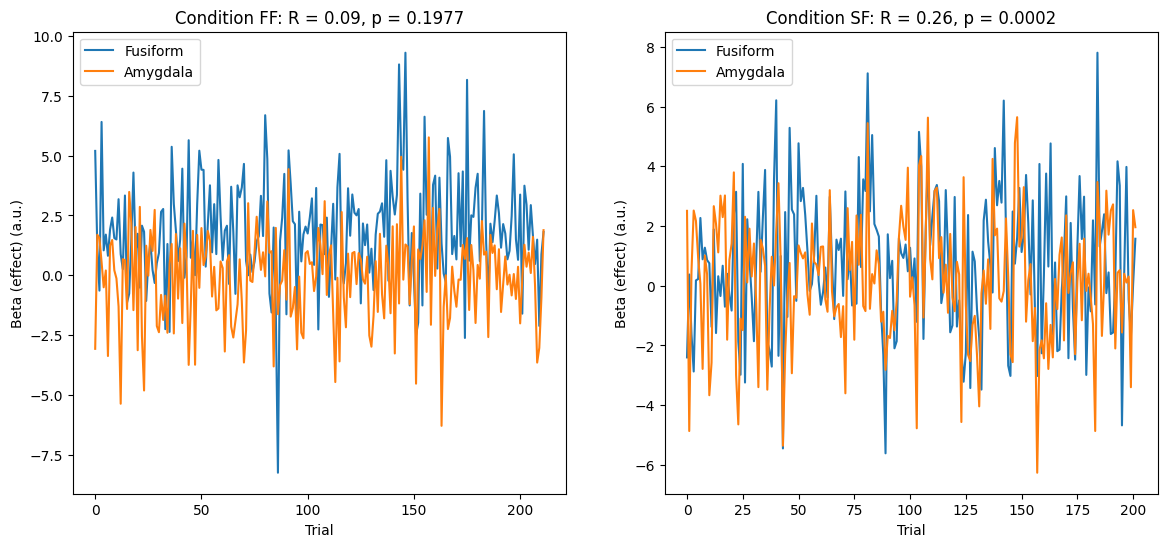

In [10]:
plt.figure(); 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6));

Rval_data = []
for ax in range(len(axs.flat)):
    pcor = pearsonr(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]])
    Rval_data.append(pcor.statistic)
    
    axs[ax].plot(fusi_data[trials_per_condition[ax]]);
    axs[ax].plot(amyg_data[trials_per_condition[ax]]);
#    axs[ax].plot(fusi_data[trials_per_condition[ax]], amyg_data[trials_per_condition[ax]],'o');
    axs[ax].set_xlabel('Trial');
    axs[ax].set_ylabel('Beta (effect) (a.u.)');
    axs[ax].legend(['Fusiform', 'Amygdala']);
    axs[ax].set_title('Condition ' + conditions[ax] + ": R = " + str(round(pcor.statistic,2)) + ", p = " + str(round(pcor.pvalue,4)));

Interestingly, the Fusiform and Amygdala ROIs seem to be more functionally connected for Scrambled than Famous faces. To test whether this difference in correlations is significant, we can use a permutation test to estimate the probability of getting such a difference in R values under the null (see Notebook on basic statistics):

Permuted p-value for difference in R values being as big as -0.17 is 0.044


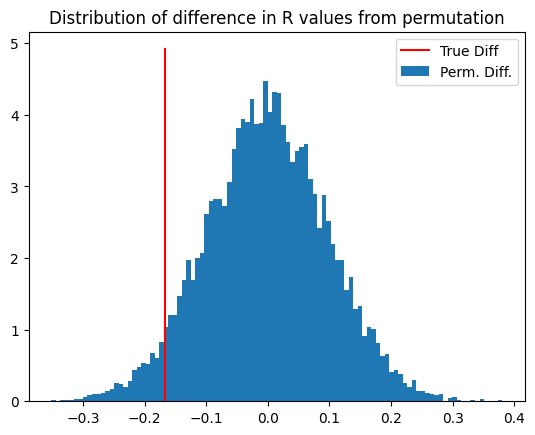

In [14]:
# generate null distributions of R-values for each condition
num_rand = int(1e4) # Number of randomisations
Rval = numpy.empty([len(conditions),num_rand])
for con, condition in enumerate(conditions):
    fusi_samp = fusi_data[trials_per_condition[con]]
    
    for r in range(num_rand):
        amyg_perm = numpy.random.permutation(amyg_data[trials_per_condition[con]])
        pcor = pearsonr(fusi_samp, amyg_perm)
        Rval[con,r] = pcor.statistic

# create null distribution of difference and true difference
Rval_dif_data = Rval_data[0] - Rval_data[1]
Rval_dif_perm = Rval[0,:] - Rval[1,:]

# plot histogram of null (permuted) and true
pdf, bin_edges = numpy.histogram(Rval_dif_perm, bins=100, density=True)
plt.figure(); plt.bar((bin_edges[:-1] + bin_edges[1:]) / 2, pdf, width=bin_edges[1] - bin_edges[0])
plt.plot([Rval_dif_data, Rval_dif_data], [0, 1.1*numpy.max(pdf)], 'r-')
plt.title('Distribution of difference in R values from permutation'); plt.legend(['True Diff', 'Perm. Diff.']);

pval = (numpy.sum(numpy.abs(Rval_dif_perm) >= numpy.abs(Rval_dif_data)) + 1) / (2*num_rand + 1) # two-tailed p-value
print(f'Permuted p-value for difference in R values being as big as {round(Rval_dif_data,2)} is {round(pval,3)}')

Thus we have a significant difference, with stronger correlation between ROIs for Scrambled than Famous faces. There is also a parametric way to compare R-values, using the Fisher transform, which we show below because we will use later to estimate voxel-wise BSR in feasible times:

In [16]:
# Convert to Z-values using Fisher transform (atanh)
difZ = numpy.arctanh(Rval_data[0]) - numpy.arctanh(Rval_data[1]) # faces - scrambled
# Fisher test given number of observations in each condition
Zdif = difZ / numpy.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) 
#two-tailed
pval = scipy.stats.norm.cdf(-abs(Zdif)) + (1-scipy.stats.norm.cdf(abs(Zdif)))
print(f'Fisher p-value for difference in Z-values being as big as {round(difZ,2)} is {round(pval,3)}')

Fisher p-value for difference in Z-values being as big as -0.17 is 0.081


### 1.2 ROI to whole brain

We can also map out BSR between a seed ROI/voxel and all other voxels in the brain. First, we first load up the whole-brain data, smoothing by 10mm to get cleaner maps (not necessary, but can improve statistics depending on spatial scale of BSR differences).

In [ ]:
brain_masker = NiftiMasker(smoothing_fwhm=10)

brain_data_per_run = []
for run in range(len(beta_filenames)):
    print(beta_filenames[run])
    brain_data = brain_masker.fit_transform(beta_filenames[run])
    brain_data_per_run.append(brain_data)
    
brain_data = numpy.concatenate(brain_data_per_run, axis=0)
print(brain_data.shape)

We can then calculate the Pearson correlation for all voxels by taking the dot product of the vector of fusiform beta-series with the matrix of beta-series for all brain voxels, and scaling by the respective norms of these beta-series (which is equivalent to the Pearson R value). We do this for each condition separately:

In [ ]:
indices = trials_per_condition[0] # conditions[0]
brain_corrs_con1 = numpy.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con1 = brain_corrs_con1 / (numpy.linalg.norm(fusi_data[indices]) * numpy.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con1 = numpy.arctanh(brain_corrs_con1) # Fisher Transform R value to Z value

indices = trials_per_condition[1] # conditions[1]
brain_corrs_con2 = numpy.dot(fusi_data[indices].T, brain_data[indices,])  # Pearson correlation proportional to dot product 
brain_corrs_con2 = brain_corrs_con2 / (numpy.linalg.norm(fusi_data[indices]) * numpy.linalg.norm(brain_data[indices,], axis=0))
#brain_corrs_con2 = numpy.arctanh(brain_corrs_con2) # Fisher Transform R value to Z value

Then we can do the Fisher test to see where differences in the correlations are significant

In [ ]:
difZ = numpy.arctanh(brain_corrs_con1) - numpy.arctanh(brain_corrs_con2) # Faces > Scrambled
Zdif = difZ / numpy.sqrt( 1 / (len(trials_per_condition[0]) - 3) + 1 / (len(trials_per_condition[1]) - 3) ) # Fisher method for comparing two independent correlations
pval = scipy.stats.norm.cdf(-abs(Zdif)) + 1-scipy.stats.norm.cdf(abs(Zdif)) #two-tailed

# convert to negative log10 (see earlier notebook), multiplied by sign of difference, and then plot
sval = numpy.sign(difZ)
pval = sval * -numpy.log10(pval)

brain_diff_con_img = brain_masker.inverse_transform(pval)
fusi_coords = (41.5, -48.5, -18.5) # from nb06
display = nilearn.plotting.plot_stat_map(brain_diff_con_img, cut_coords=fusi_coords, threshold = -numpy.log10(0.001),
    title="Signed log10 p-values for greater Beta Series correlation from Fusiform ROI for " + conditions[1] + " than " + conditions[0])

Blue clusters around the amygdala echo what we found in the ROI-to-ROI analysis above, while the red clusters in more posterior occipital regions indicate stronger correlation with the fusiform when famous faces are presented relative to scrambled faces.

## 2. State-based time-series correlation (from task residuals)

Finally, we will do some analyses similar to what you might do for resting-state fMRI, ie correlations between the original fMRI timeseries. Unfortunately this dataset does not have a proper resting-state run, but we can estimate this by removing (as best as possible) the effects of the task. The resulting timeseries reflect whatever is happening during the times between trials (note that there are short periods of rest between blocks of trials in this design).

First let's load the raw fMRI volumes for the current subject, and recreate their design matrix:

In [ ]:
bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename')
nvols = nibabel.load(bold[0]).shape[-1] # assume same for all runs
print(f"Found {nvols} preprocessed functional files (dfs) for each of {len(bold)} runs")


There are three main types of non-neural noise in fMRI timeseries: motion-related, physiological artifacts (like breathing) and instrumental noise (like scanner drift). We address each of these in turn.

### 2.1 Confounds and expansion of motion parameters

As in the notebook on subject-level models, we will collect the confounds created by fMRIPrep, but this time we will use some more than just the motion paramerers, since we want to ensure that any correlation between voxel timeseries (TSC) does not owe to noise sources like bioryhthms (eg breathing) that are shared across many voxels (we want it to reflect primarily neural activity). (Note that these additional confounds are less important for the task-based analysis we did in previous notebooks, because they are unlikely to be phase-locked to the regressors in our design matrix, so just appeared in the residual error, whereas for TSC we have no design matrix and the Pearson correlation estimate of functional connectivity depends on phase-locking across voxels.)

First we will load the 6 motion parameters, but this time take various expansions of them, like their squares and the difference between successive TRs. These are to capture nonlinear and time-lagged artifacts caused by motion (like spin-history effects for example). These are sometimes called the "Sattherthwaite 24" set. They are already created by fMRIPrep, but we recreate them below for clarity. 

We will also add signal recorded from the white-matter (WM) and cerebrospinal fluid (CSF) partitions created by fMRIPrep, to capture biorhythms that should not contain any neural activity (unless contaminated by partial grey-matter volumes): 

In [ ]:
confound_files = layout.get(subject = sID, datatype = 'func', desc = 'confounds', extension = ".tsv", return_type = 'filename')
motion_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
other_confounds  = ['csf', 'white_matter']

confounds_per_run = []
for conf_file in confound_files:
    this_conf = pandas.read_table(conf_file)
    motion_subset = this_conf[motion_confounds].fillna(0) # replace NaN with 0
    motion_change = motion_subset.diff().fillna(0)
    motion_change.columns = 'diff_' + motion_subset.columns
    motion_square = motion_subset.pow(2)
    motion_square.columns = 'sq_' + motion_subset.columns 
    motion_change_square = motion_change.pow(2)
    motion_change_square.columns = 'sq_' + motion_change.columns
    motion_24 = pandas.concat([motion_subset, motion_change, motion_square, motion_change_square], axis=1)
    confounds = pandas.concat([motion_24, this_conf[other_confounds].fillna(0)], axis=1)
    confounds = (confounds - confounds.mean())/(confounds.std()) # Z-score just for visualisation
    confounds_per_run.append(confounds)
    
print(f"Using around {confounds_per_run[0].shape[1]} dfs per run to remove motion, CSF and WM effects")
confounds_per_run[-1].head() # show last run

### 2.2 Global Signal

Another potential signature of physiological noise is the "global signal", the average timeseries over all brain voxels. Such "global signal regression" is contentious however: while it can be quite effective at removing noise, it can also remove true neural signal that happens to occur in many voxels. It also produces many negative Pearson correlation coefficients, since some pairs of voxels will be correlated, but less than the correlation between any voxel and the average. Negative correlations might be interpretable in terms of less-than-average connectivity (or true neural anti-correlation), but some argue that we should focus on positive correlations only (eg for graph-theoretic analysis in next notebook).

Again, global signla is in the confounds file fromy fMRIprep, but we will recreate to show how it is calculated:

In [ ]:
bold_images = nilearn.image.load_img(bold[-1]) # choose last run where may be most motion for illustration

mean_bold = nilearn.image.mean_img(bold_images) # create mean across time
bold_mask = nilearn.masking.compute_epi_mask(mean_bold)

print("Before masking, our data has shape %s ..." % (bold_images.shape,))
bold_masked = nilearn.masking.apply_mask(bold_images, bold_mask) 
print("... and afterwards our data has shape %s and is a %s" % (bold_masked.shape, type(bold_masked).__name__))
global_signal = numpy.mean(bold_masked,axis=1)

plt.figure(); plt.plot(global_signal)
ax = plt.gca(); ax.set_title('Global signal from last run'); ax.set_ylabel('BOLD (a.u.)');  ax.set_xlabel('TR');
plt.show()

(If you did want to use any additional covariates from the fMRIPrep confounds file, for each run, then you could run something like (using global signal as example):

```python
for run in range(len(confound_files)):
    global_signal = pandas.read_table(confound_files[run], usecols = ["global_signal"])
    global_signal = (global_signal -  global_signal.mean()) /  global_signal.std()
    confounds_per_run[run] = pandas.concat([confounds_per_run[run], global_signal], axis=1)
```

### 2.3 Instrumental (scanner) noise (and aliased biorhythms)

The last main source of noise relates to instrumental noise like scanner drift (the BOLD signal typically drifts up and down over time, eg due to changes in temperature). This tends to be low-frequency, so we can remove by high-pass filtering the data. 

In fact, high-pass filtering also removes other types of physiological noise that is of higher frequency than our sampling rate. For example, pulse is typically 1Hz, which is above the Nyquist limit if we sample with a TR=2 (ie 0.5 Hz). This type of noise therefore becomes aliased into lower-frequencies, so also removed by high-pass filtering.

Some people also apply a low-pass filter (i.e, a band-pass filter), but it is unclear whether this is important (see [Geerligs et al (2017)](https://pmc.ncbi.nlm.nih.gov/articles/PMC5518296/) for example). We will examine effects of filtering (and removal of other confounds) by using carpet plots.

### 2.4 Carpet plots

A convenient way to examine the timeseries across many voxels is to produce a "carpet plot", showing time (TR) horizontally and voxel vertically

In [ ]:
TR = layout.get_tr()

atlas_dir = os.path.join(wd, 'atlases')
if not os.path.exists(atlas_dir):
    os.makedirs(atlas_dir)

# Download an atlas definition of GM, WM and CSF voxels
atlas = nilearn.datasets.fetch_icbm152_2009(data_dir = atlas_dir) # this downloads an atlas
atlas_img = image.concat_imgs((atlas["gm"], atlas["wm"], atlas["csf"])) # we select these segments
map_labels={"Gray Matter": 1, "White Matter": 2, "Cerebrospinal Fluid": 3} # assign them labels
atlas_data = atlas_img.get_fdata() # Get data from images

In [ ]:
# These images contain probabilities of each tissue-type, which we can binarize by taking the maximum across tissue-types for each voxel
discrete_version = numpy.argmax(atlas_data, axis = 3) + 1    # index of maximum value across GM, WM and CSF for each voxel
discrete_version[numpy.max(atlas_data, axis = 3) == 0] = 0   # reset everything
discrete_atlas_img = image.new_img_like(atlas_img,discrete_version) # make an image

# Plot image of segments (suppressing warning about data-type)
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
plotting.plot_stat_map(discrete_atlas_img,cmap='tab20b');

#### 2.4.1 Raw carpet

We can now use these labels to indicate which parts of our carpet plot come from which tissue-type:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(
    bold_images,
    discrete_atlas_img,
    t_r = TR,
    mask_labels = map_labels,
    axes = ax, title='Raw BOLD timeseries',
    cmap="gray")
fig.show();

This is not a particularly bad run - in some cases you might see vertical stripes indicating large motion at a certain time, or high variance in some voxels. Here there seems to be a bit more variance at start of run, and possibly some artifact around 65 TRs. 

#### 2.4.2 Filtered carpet

Let's see the effect of applying the high-pass filter:

In [ ]:
high_pass_cut   = 0.008; # cut-off (typically choice - filtering too much removes dfs in our data)
brain_masker    = NiftiMasker(standardize='zscore', high_pass = high_pass_cut, t_r = TR) # highpass filtering
filtered_data   = brain_masker.fit_transform(bold_images)
filtered_images = brain_masker.inverse_transform(filtered_data) 

fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(filtered_images, discrete_atlas_img, t_r = TR, mask_labels = map_labels, axes = ax, title='Filtered BOLD timeseries', cmap="gray")
fig.show();

Filtering has not done anything obvious to the carpet plot, except perhaps introduce some filtering end-effects towards end of run (which do not matter because they same is true of all voxels we will correlate). What about the effects of removing the confounds we created above?

#### 2.4.3 Deconfounded carpet

Let's see what happens when we remove our 26 confounds (note we are not including global signal in our confounds here):

In [ ]:
confounds_to_remove = numpy.asarray(confounds_per_run[-1]) # take confounds from last run to match data

deconfounded_data   = brain_masker.fit_transform(bold_images, confounds = confounds_to_remove) 
deconfounded_images = brain_masker.inverse_transform(deconfounded_data) # Note it does not invert any signal processing done to the image (see https://nilearn.github.io/stable/manipulating_images/masker_objects.html)

fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(deconfounded_images, discrete_atlas_img, t_r = TR, mask_labels = map_labels, axes = ax, title='Filtered, deconfounded BOLD timeseries', cmap="gray")
fig.show()

This looks a bit cleaner (e.g. at start of run), though effects may be more dramatic in other datasets, eg from children (try your data!)

This would be sufficient for resting-state data, but in our data, we still have taskBut we still have responses related to the task, ie each trial that a stimulus was presented. 

#### 2.4.4 Removing task-effects

In our task data, if we correlated voxel time-series from the deconfounded data above, there might be high correlation between some brain regions simply because they independently responded to the same trials. To remove this, we can use the regressors we created in our GLM in previous notebooks.

One way to remove this variance would be to use the LSA model we used in the MVPA notebook, i.e. adjust for a separate regressor for each trial. This would allow for fact that the amplitude of BOLD response might vary across trials of the same type (e.g, to fluctuations in attention), which the standard, one-regressor-per-condition (LSU) model would not allow for. However, the flexibility of LSA model can also fit noise (particularly with short-SOA event-related designs like ours) - at least fluctuations in the BOLD response that are not due to the trials themselves - ie remove true functional connectivity. We therefore use the standard LSU model here (but you can try the LSA model by uncommenting lines below, in which case you should observe that a strong resting-block structure emerges, suggesting it may indeed be over-fitting).

Note that in general, it is difficult to remove all possible task-related signal, because in addition to amplitude variation across trials, the canonical HRF used may not be a perfect match for a particular subject and brain region. This could be resolved by using a more flexible basis set to model the HRF, though combining both LSA and a flexible basis set is infeasible except with long SOAs.

In [ ]:
events_df = pandas.read_table(events_files[-1])

# If want to create a LSA model with all trials of ALL conditions
#for j, event in enumerate(events_df['trial_type']):
#   events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]

events = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])

slice_timing = layout.get_metadata(bold[-1])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR

# Create a design matrix without actually fitting data, which just requires from dummy frame times
frame_times = numpy.linspace(0, (nvols - 1) * TR, nvols)
design_matrix = nilearn.glm.first_level.make_first_level_design_matrix(frame_times, events = events, hrf_model = 'glover', drift_model = 'cosine', high_pass = 0, drift_order = None)
# Note do not need highpass filter terms
nilearn.plotting.plot_design_matrix(design_matrix, output_file = None)
fig = plt.gcf(); fig.set_size_inches(8,2); plt.show()

We can now treat these task-related regressors as confounds too:

In [ ]:
trial_regressors = numpy.asarray(design_matrix)
trial_regressors = trial_regressors[:,:-1] # do not need constant

print(f"Using {trial_regressors.shape[1]} trial regressors, ie a total of {trial_regressors.shape[1] + confounds_to_remove.shape[1]} confound regressors from {nvols} TRs (though also df loss from highpass filtering)")

deconfounded_detasked_data   = brain_masker.fit_transform(bold_images, confounds = numpy.concatenate([confounds_to_remove, trial_regressors], axis=1))
deconfounded_detasked_images = brain_masker.inverse_transform(deconfounded_detasked_data) 

fig, ax = plt.subplots(figsize=(12, 8))
display = plotting.plot_carpet(deconfounded_detasked_images, discrete_atlas_img, t_r = TR, mask_labels = map_labels, axes = ax, title='Filtered, deconfounded, task-adjusted BOLD timeseries', cmap="gray")
fig.show();

We can now estimate the correlation between all (grey-matter) voxels. We use a brain masker for this, now also adding standardisation (Z-scoring) and some spatial smoothing (to reduce noise, on assumption that functional connectivity operates over this space scale)

In [ ]:
#voxels_data = deconfounded_detasked_data # smoothing helps, so re-mask with smoothing
brain_masker = NiftiMasker(standardize='zscore', high_pass = high_pass_cut, t_r = TR, smoothing_fwhm = 6) 
voxels_data  = brain_masker.fit_transform(bold_images, confounds = numpy.concatenate([confounds_to_remove, trial_regressors], axis=1))

fusi_masker = NiftiMasker(fusi_ROI, high_pass = high_pass_cut, t_r = TR) # no need for smoothing since will average over ROI
seed_data   = fusi_masker.fit_transform(bold_images, confounds = numpy.concatenate([confounds_to_remove, trial_regressors], axis=1))
seed_data   = numpy.mean(seed_data, axis=1) # average across voxels
seed_data   = (seed_data - numpy.mean(seed_data)) / numpy.std(seed_data) # zscore
                                                 
seed_to_voxel_correlations = numpy.dot(seed_data.T, voxels_data)/seed_data.shape[0]
print("Correlation min = " + str(numpy.min(seed_to_voxel_correlations)) + ", max = " + str(numpy.max(seed_to_voxel_correlations)))
seed_to_voxel_correlations_fisher_z = numpy.arctanh(seed_to_voxel_correlations)

We can now produce an image of voxels with various correlation strengths with our fusiform ROI - note of course the voxels in the right fusiform will have very high values because they are spatially part of the seed region. Although the map is a bit noisy, the left fusiform at least is highly correlated, and this cannot be due to spatial overlap with the seed. The map is noisy because we only analysed one run; more powerful statistics can be obtained by cleaning each run separately, then concatenating over runs and taking the correlation (would just take a bit longer to run).

In [ ]:
# convert the numpy array back into a nifti image
seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(seed_to_voxel_correlations_fisher_z)
# apply brain mask
seed_to_voxel_correlations_fisher_z_img = nilearn.image.math_img('(in_mask * data)', in_mask=bold_mask, data=seed_to_voxel_correlations_fisher_z_img)
seed_to_voxel_fname = 'fcon_fusi_seed.nii.gz'
seed_to_voxel_correlations_fisher_z_img.to_filename(seed_to_voxel_fname) 

MNI_coord = (41.5,	-48.5,	-18.5)
display = nilearn.plotting.plot_stat_map(seed_to_voxel_fname, cut_coords = MNI_coord, threshold = 0.2,
    title="Z-values for functional correlation with fusiform peak voxel")

### 2.5 Atlas-based connectome

We can also divide (parcellate) the brain into a number (eg few hundred) ROIs based on an atlas in MNI space. There are a large number of such atlases, some in which the ROIs are defined anatomically, others where they are defined functionally, e.g. by clustering functional connectivity results in other datasets. Here we will use the "Schaefer" atlas of 500 ROIs, which is bundled with nilearn, and comes with a labelling in which those ROIs have already been defined according to 17 "Yeo" networks:  

In [ ]:
# download the 500 ROI version of Schaefer atlas, which can be organised into 17 networks according to Yeo
dataset_schaefer = datasets.fetch_atlas_schaefer_2018(n_rois = 500, yeo_networks = 17, data_dir = atlas_out, resolution_mm=2)

schaefer_atlas_filename = dataset_schaefer.maps
temp_atlas = image.load_img(schaefer_atlas_filename)
print(f'Shape of Atlas - {temp_atlas.shape}') # The atlas is one 3D image in which each voxel is coded by a number that indicates to which ROI it belongs
plotting.plot_roi(schaefer_atlas_filename, colorbar = True, interpolation = 'nearest');

We can now mark each ROI with a Yeo network as below (bit hacky!)

In [ ]:
# Hacky code to convert Schaefer network label bytes to integers for ordering
schaefer_df = pandas.DataFrame(dataset_schaefer)
#schaefer_df.head(5) # see data as bytes

# new network names to define
network_names = ["VisCent","VisPeri","SomMotA","SomMotB","DorsAttnA","DorsAttnB","SalVentAttnA","SalVentAttnB","LimbicA","LimbicB","ContA","ContB","ContC","DefaultA","DefaultB","DefaultC","TempPar"];
network_numbers = list(range(1,len(network_names)+1))

# number networks for each ROI
schaefer_df['network_number'] = 0
for idx, i_str in enumerate(network_names):
  label = schaefer_df['labels'].astype(str).str.contains(i_str)
  schaefer_df.loc[label, 'NetNumber'] = network_numbers[idx]

# Initialise new dataframe
new_df = schaefer_df.copy()
new_df['ROI_Number'] = new_df.index
new_df = new_df.sort_values(by=['NetNumber'])
reorder_index_schaefer = new_df.ROI_Number.values
network_numbers = new_df.NetNumber.values
new_df.head()

Now we can calculate correlation between every pair of ROIs (now using nileaarn's ConnectivityMeasure)

In [ ]:
# Define how functional connectivity measured
correlation_measure = nilearn.connectome.ConnectivityMeasure(kind='correlation')

# Get data for Schaefer ROIs
schaefer_masker = nilearn.maskers.NiftiLabelsMasker(labels_img = schaefer_atlas_filename,
                            standardize = 'zscore',
                            detrend = False,
                            high_pass = high_pass_cut,
                            t_r = TR, verbose = 1)
time_series_clean_schaefer = schaefer_masker.fit_transform(bold_images, confounds = numpy.concatenate([confounds_to_remove, trial_regressors], axis=1))

# Calculate correlations
correlation_matrix_schaefer = correlation_measure.fit_transform([time_series_clean_schaefer])[0]

# Mask the main diagonal for visualization
numpy.fill_diagonal(correlation_matrix_schaefer, 0)

We can now plot a 500x500 connectivity matrix (connectome), with ROIs ordered as they are in original atlas, in which left ROIs are numbered first, then right ROIs. As a consequence, you can see a second "diagonal" stripe half-way across from the main diagonal, which represents connectivity between homologous ROIs across hemispheres. This connectivity always tends to be high, so not seeing this homologous diagonal can be a sign that something has gone wrong.

In [ ]:
# Plot correlation matrix by ROI number (showing laterality effects)
plt.figure(figsize=(10,8)); ax = plt.gca()
display = plotting.plot_matrix(correlation_matrix_schaefer,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax, title='Ordered by left then right ROIs');
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10);

We can also reorder the ROIs by networks (using the new numbered we calculated earlier). Now you should see block-like structures along the main diagonal, reflecting higher connectivity within networks than between networks.

In [ ]:
# Plot correlation matrix by Network
plt.figure(figsize=(10,8)); ax = plt.gca()
reorder_corr = correlation_matrix_schaefer[reorder_index_schaefer][:,reorder_index_schaefer];
display = plotting.plot_matrix(reorder_corr,
                     vmax=0.8, vmin=-0.8, reorder=False,axes=ax,title='Ordered by Network');
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10);

This concludes this functional connectivity notebook (for the moment) - we will analyse such connectomes in the next notebook on network (graph) theory.